In [14]:
validationSplit = 0.2
seed = 124
imageSize = (256, 256)
batchSize = 64
numClasses = 44
learningRate = 0.0001
epochs = 30
outDir = "evaluations"

In [15]:
!nvidia-smi

Thu Jul  6 10:12:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [16]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from enum import Enum
import tensorflow as tf
from tensorflow.data import AUTOTUNE
from tensorflow.keras import Input, Model
from tensorflow.keras.applications import InceptionV3, Xception
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory

sns.set_theme(style="darkgrid")

In [18]:
# check whether the environemnt is google colab or kaggle or paperspace or local
isColab = False
isKaggle = False

if "google.colab" in str(get_ipython()):
    isColab = True
elif os.path.exists("/kaggle/working"):
    isKaggle = True

# connect to Google Drive
if isColab:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    baseDir = f"/content/drive/MyDrive/Leaf Image Synthesis"
elif isKaggle:
    os.makedirs(outDir)
    os.makedirs(f"{outDir}/clfs")
    os.makedirs(f"{outDir}/clfs-history")
else:
    baseDir = f"."

# move to the base folder
%cd $baseDir

FileExistsError: [Errno 17] File exists: 'evaluations'

In [20]:
class Clf(Enum):
    INCEPTION_V3 = "Inceptionv3"
    XCEPTION = "Xception"

In [21]:
def loadDataset(trainDir, testDir, validationSplit, seed, imageSize, batchSize):
    trainDs = image_dataset_from_directory(
        trainDir,
        validation_split=validationSplit,
        seed=seed,
        image_size=imageSize,
        batch_size=batchSize,
        subset="training"
    )

    valDs = image_dataset_from_directory(
        trainDir,
        validation_split=validationSplit,
        seed=seed,
        image_size=imageSize,
        batch_size=batchSize,
        subset="validation"
    )

    testDs = image_dataset_from_directory(
        testDir,
        image_size=imageSize,
        batch_size=batchSize
    )

    print(f"Using {len(trainDs):4} files for training")
    print(f"Using {len(valDs):4} files for validation")
    print(f"Using {len(testDs):4} files for testing")

    return trainDs, valDs, testDs

In [22]:
def showSampleImage(ds, rows, cols):
    classNames = ds.class_names
    total = rows * cols
    fig = plt.figure(figsize=(6, 6))
    fig.suptitle("Sample Images")
    for images, labels in ds.take(1):
        for i in range(total):
            ax = plt.subplot(rows, cols, i + 1)
            img = images[i].numpy().astype("uint8")
            plt.title(classNames[labels[i]])
            plt.axis("off")
            plt.imshow(img)

    plt.show()

In [23]:
def plotClfScoreLineGraph(df, metric, figPath=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(data=df, x="epoch", y=metric, label=f"Train {metric}")
    sns.lineplot(data=df, x="epoch",
                 y=f"val_{metric}", label=f"Validation {metric}")
    plt.xlabel("Training epochs (kimg)")
    plt.ylabel(f"Score ({metric})")
    model = f'{df["experiment"][0]} - {df["classifier"][0]}'
    plt.title(f"{model} ({metric})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if figPath:
        saveFig(figPath, fig)

In [24]:
def plotClfScoreBarGraph(df, metric, figPath=None):
    df = df.sort_values(by=metric, ascending=False).reset_index(drop=True)
    display(df)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=df, x="experiment", y=metric, color="tab:blue", errorbar=None)
    ax.patches[0].set_facecolor("tab:red")

    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Experiment")
    plt.ylabel(f"Score ({metric})")
    model = df["classifier"][0]
    plt.title(f"{model} ({metric})")

    for i, v in enumerate(df[metric]):
        plt.text(i, v, f"{v:.4f}", ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

    if figPath:
        saveFig(figPath, fig)

In [25]:
def formatTrainScores(df, experiment, classifier, accImgPath=None, lossImgPath=None):
    df["experiment"] = experiment
    df["classifier"] = classifier
    df["epoch"] = df.index + 1
    print("Training accuracy and loss:")
    plotClfScoreLineGraph(df, "accuracy", accImgPath)
    plotClfScoreLineGraph(df, "loss", lossImgPath)
    return df

In [26]:
def formatTestScores(results, experiment, classifier):
    dfTestScores = pd.DataFrame([{
        "experiment": experiment,
        "classifier": classifier,
        "accuracy": results[1],
        "loss": results[0],
    }])
    print("Testing accuracy and loss:")
    display(dfTestScores)
    return dfTestScores

In [27]:
def trainModel(classifier, trainDir, testDir, num_gpus=2):
    # Set up the strategy for multi-GPU training
    strategy = tf.distribute.MirroredStrategy(devices=["GPU:{}".format(i) for i in range(num_gpus)])

    experiment = os.path.split(trainDir)[-1]
    print(f"Experiment: {experiment}")
    modelName = f"{experiment}-{classifier.value}"
    print(f"Training {modelName}\n")

    with strategy.scope():
        # load dataset
        trainDs, valDs, testDs = loadDataset(trainDir, testDir, validationSplit, seed, imageSize, batchSize)

        showSampleImage(trainDs, 3, 3)

        # create a base model
        inputShape = imageSize + (3, )
        if classifier == Clf.INCEPTION_V3:
            baseModel = tf.keras.applications.InceptionV3(
                input_shape=inputShape,
                weights="imagenet",
                include_top=False)
        elif classifier == Clf.XCEPTION:
            baseModel = tf.keras.applications.Xception(
                input_shape=inputShape,
                weights="imagenet",
                include_top=False)
        else:
            raise ValueError("Invalid classifier name")

        # create a top model
        inputs = tf.keras.Input(shape=inputShape)
        x = tf.keras.applications.imagenet_utils.preprocess_input(inputs)
        x = baseModel(x, training=False)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        outputs = tf.keras.layers.Dense(numClasses, activation="softmax")(x)
        model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

        # define loss and optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate)
        lossFn = tf.keras.losses.SparseCategoricalCrossentropy()
        metrics = ["accuracy"]

        # compile model
        model.compile(optimizer=optimizer, loss=lossFn, metrics=metrics)

    # train model
    history = model.fit(trainDs, epochs=epochs, validation_data=valDs)

    # save model
    modelPath = os.path.join(outDir, "clfs", modelName)
    model.save(modelPath)
    print(f"{modelPath} is saved")

    # plot training accuracy and loss
    dfTrainScores = pd.DataFrame(history.history)
    formatTrainScores(dfTrainScores, experiment, classifier.value)

    # test model
    results = model.evaluate(testDs, batch_size=batchSize)
    formatTestScores(results, experiment, classifier.value)

### Single - Folder

Using /kaggle/input/feature-vector-ed-fd-all-r10-1000/ed-fd-all-r10-1000 as classifier training input
Experiment: ed-fd-all-r10-1000
Training ed-fd-all-r10-1000-Xception

Found 44000 files belonging to 44 classes.
Using 35200 files for training.
Found 44000 files belonging to 44 classes.
Using 8800 files for validation.
Found 528 files belonging to 44 classes.
Using  550 files for training
Using  138 files for validation
Using    9 files for testing


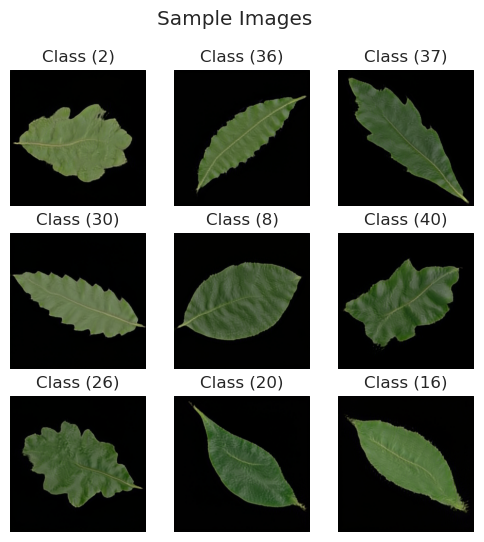

83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/30
 49/550 [=>............................] - ETA: 6:21 - loss: 4.0641 - accuracy: 0.0252

In [ ]:
testDataDir = "../input/mk-test/mk-test"

experiment = "ed-fd-all-r10-1000"
imgDir = f"/kaggle/input/feature-vector-{experiment}/{experiment}"
if os.path.isdir(imgDir):
    print(f"Using {imgDir} as classifier training input")
    trainDir = imgDir
    trainModel(Clf.XCEPTION, imgDir, testDataDir)